In [11]:
import anndata as ad
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sys
import torch
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

### Silhoutte score

In [12]:
meta = pd.read_csv('../bmmc.meta.s3s4.csv')
out_x = pd.read_csv('bindSC_embed.rna.s3s4.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('bindSC_embed.atac.s3s4.txt',header=None).iloc[:,1:].to_numpy()


In [13]:
from sklearn.metrics import silhouette_score
merge = np.concatenate((out_x, out_y), axis=0)

ct_name = meta['cell_type'].to_numpy()

batch_name = meta['batch'].to_numpy()

silhouette_ct = silhouette_score(merge, ct_name)
#silhouette_tech = silhouette_score(merge, tech_int)
silhouette_batch = silhouette_score(merge, batch_name)


### Joint embedding

In [15]:
merge = np.concatenate((out_x, out_y), axis=0)
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = ct_name
ann_merge.obs['batch'] = batch_name
domains = np.zeros(len(merge))
domains = domains.astype('str')
domains[0:out_x.shape[0]] = 'GEX'
domains[out_x.shape[0]:] = 'ATAC'
#domains = domains.astype('int')
ann_merge.obs['tech'] = domains
ann_merge.obs['tech'] = ann_merge.obs['tech'].astype("category")

... storing 'cell_type' as categorical
... storing 'batch' as categorical


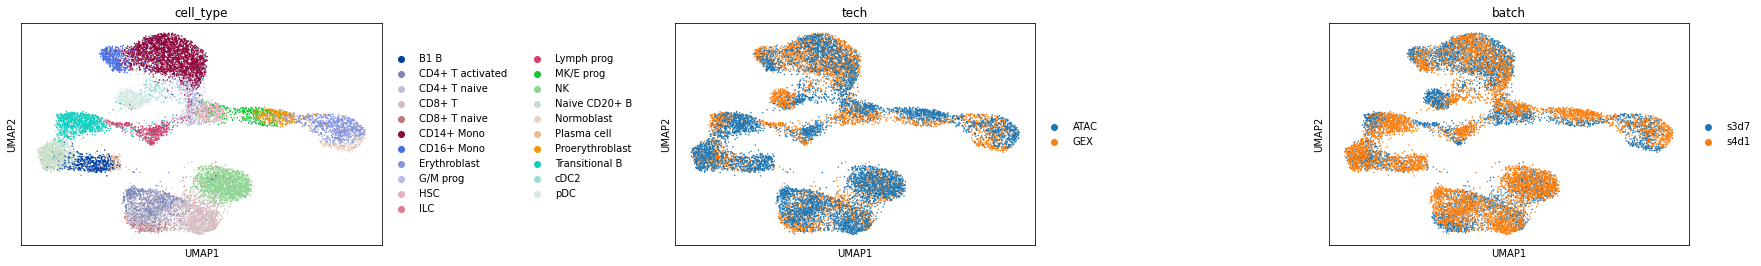

In [16]:
import scanpy as sc
#sc.pp.neighbors(ann_merge, use_rep="X", metric="cosine")
#sc.tl.umap(ann_merge)
#sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)

sc.tl.pca(ann_merge, svd_solver='arpack')
sc.pp.neighbors(ann_merge, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(ann_merge)
sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)


In [17]:
combined_embed = pd.DataFrame(ann_merge.obsm['X_umap'])
combined_embed.insert(0, 'index', ann_merge.obs_names.to_numpy())
combined_embed.columns = ['index','UMAP_1','UMAP_2']
combined_embed.to_csv('../results/raw/bindSC_UMAP.s3s4.txt', index=False)

### Lable transfer prediction

In [7]:
meta = pd.read_csv('../bmmc.meta.s3s4.csv')
out_x = pd.read_csv('bindsc_embed.rna.s3s4.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('bindsc_embed.atac.s3s4.txt',header=None).iloc[:,1:].to_numpy()


In [8]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

def KNN_acc(out_x, out_y, labels_x, labels_y, nn=5):
    neigh = KNeighborsClassifier(n_neighbors=nn, weights='distance')
    neigh.fit(out_x, labels_x)
    labels_pred = neigh.predict(out_y)
    #print(check)
    acc = np.mean(labels_y == labels_pred)
    print("Accuracy is %s"%(acc))
    return labels_pred

In [9]:
labels_x = meta['cell_type'].to_numpy()[0:out_x.shape[0]]
labels_y = meta['cell_type'].to_numpy()[out_x.shape[0]:]


In [10]:
#200
#Accuracy is 0.6485242127764532
#for i in range(205,305,5):
#    print(i)
#    pred_y = KNN_acc(merge, labels, nn=i)
#    print()
pred_y = KNN_acc(out_x, out_y, labels_x, labels_y, nn=25)

Accuracy is 0.7155494125777471


In [11]:
pred_df = pd.DataFrame({'cell_type':labels_y,'prediction':pred_y})
pred_df.to_csv('../results/raw/bindSC_prediction.s3s4.txt')

In [13]:
ct_df = pd.DataFrame({'cell_type':labels_y,
                     'prediction':pred_y})
n_ct = len(np.unique(labels_y))
ct_heatmap = pd.DataFrame(np.zeros((n_ct,n_ct)))
ct_heatmap.index = meta['cell_type'][out_x.shape[0]:].unique().tolist()
ct_heatmap.columns = meta['cell_type'][out_x.shape[0]:].unique().tolist()
for i in range(n_ct):
    for j in range(n_ct):
        tmp = ct_df.loc[(ct_df['cell_type'] == ct_heatmap.index[i]),:]
        ct_heatmap.iloc[i,j] = np.mean(tmp['prediction'] == ct_heatmap.columns[j])
        

<AxesSubplot:>

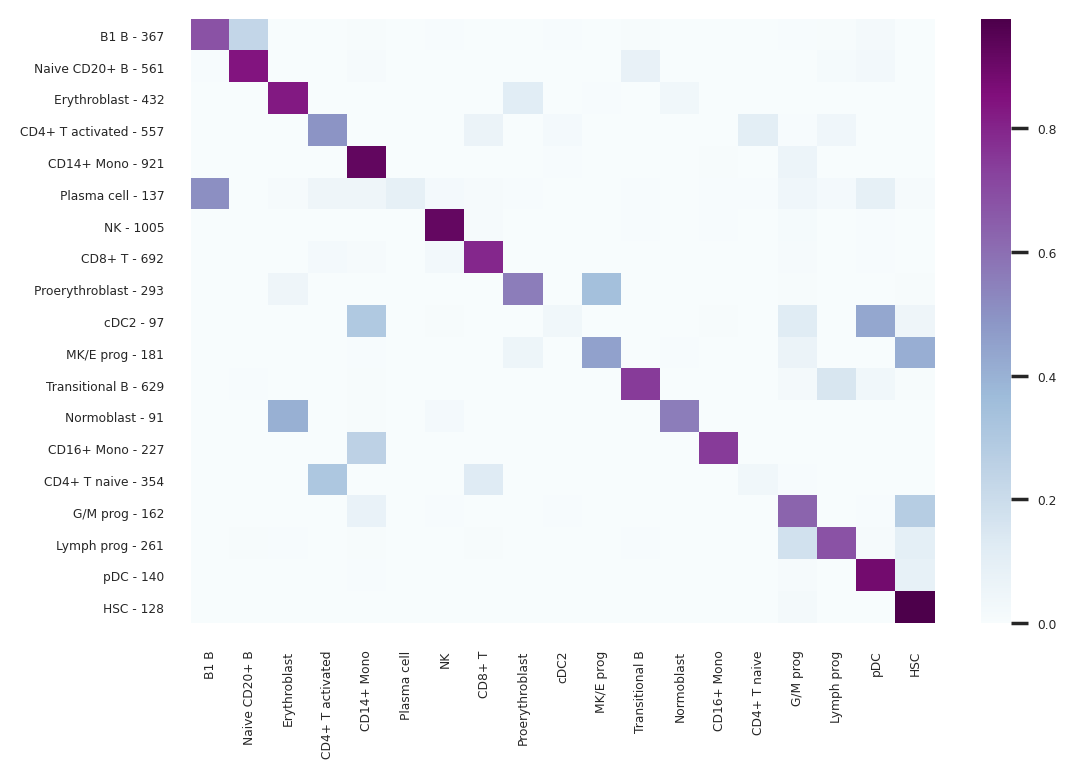

In [14]:
ct_heatmap.index = ct_heatmap.index + ' - ' + ct_df['cell_type'].value_counts().astype(str)[ct_heatmap.index]
sns.set(rc={"figure.dpi":200, 'savefig.dpi':100},font_scale=0.4)
mask = ct_heatmap.isnull()
sns.heatmap(ct_heatmap, mask=mask, cmap="BuPu")

In [15]:
acc_df = pd.DataFrame({'cell_type':ct_heatmap.columns.tolist(),
                       'bindSC': np.diag(ct_heatmap)})

In [16]:
acc_df.to_csv('../results/raw/bindSC_transfer_acc.s3s4.csv')

In [19]:
meta = pd.read_csv('../bmmc.meta.s3s4.csv')
out_x = pd.read_csv('bindsc_embed.rna.s3s4.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('bindsc_embed.atac.s3s4.txt',header=None).iloc[:,1:].to_numpy()
merge = np.concatenate((out_x, out_y), axis=0)
merge = pd.DataFrame(merge)
merge.insert(0, 'index', meta.index.to_numpy())
merge.to_csv('../results/raw/bindsc_embed.s3s4.txt', index=False)
